In [1]:
#@title Imports
from sklearn.metrics import f1_score
import requests, os, zipfile
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import math
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
import sklearn.metrics as metrics
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional

import copy
from collections import namedtuple
import random
import shutil
import time
# Path to the events archive
dataset_zip = '/tmp/glaucoma.zip'

# Path to the extracted events
dataset_dir = '/tmp/dataset/'

# Path to the dataset file
dataset_pkl = '/tmp/dataset.zip'

# Path to the model
model_path = '/tmp/'

In [2]:
#@title Dataset Download

import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Download the dataset combined
#download_file_from_google_drive('1XbECYqiqKzlBOsd7DfhK9LwXV1rSmNUD', dataset_zip)
download_file_from_google_drive('1Nz0WQToBpYTv2j4xWxF5YNonMmRQ2vok', dataset_zip)
# Unzip the dataset
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [3]:
#@title Dataset paths
# Paths to event files
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

In [4]:
#@title Print Dataset Statistics


train_images = glob.glob(os.path.join(train_dir,'*', '*.jpg'))
validation_images = glob.glob(os.path.join(validation_dir,'*', '*.jpg'))
test_images = glob.glob(os.path.join(test_dir,'*', '*.jpg'))

train_classes = [os.path.basename(os.path.dirname(x)) for x in train_images]
validation_classes = [os.path.basename(os.path.dirname(x)) for x in validation_images]
test_classes = [os.path.basename(os.path.dirname(x)) for x in test_images]

assert len(set(train_classes))==len(set(validation_classes)), 'Class mismatch between train and val'
classes = set(train_classes)
num_classes = len(classes)

for class_ in classes:
  print('Class {}: training images: {}, test images: {}, validation images: {}'.format(class_, train_classes.count(class_), test_classes.count(class_), validation_classes.count(class_)))
print('\nTotal training images:', len(train_images))
print('Total test images:', len(test_images))
print('Total validation images:', len(validation_images))

print('Number of classes:', num_classes)

Class GL: training images: 1486, test images: 188, validation images: 185
Class HE: training images: 2650, test images: 333, validation images: 330

Total training images: 4136
Total test images: 521
Total validation images: 515
Number of classes: 2


In [5]:
#@title PRECODE
import math
from numbers import Number

import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.autograd import Variable


class VariationalBottleneck(torch.nn.Module):
    """
    Implementation inspired by https://github.com/1Konny/VIB-pytorch/blob/master/model.py
    """
    def __init__(self, in_shape, K=256, beta=1e-3):
        super().__init__()
        self.in_shape = in_shape
        self.K = K
        self.beta = beta

        if len(in_shape) == 1: # previous layer is a Linear layer
            enc_in_dim = in_shape[0]
            self.reducer = None
        else: 
            enc_in_dim = np.prod(in_shape[1:])
            self.reducer = nn.Conv2d(in_shape[0], 1, 1)

        self.encoder = nn.Linear(enc_in_dim, 2 * self.K)
        self.decoder = nn.Linear(self.K, np.prod(in_shape))

        self.mu = Variable(torch.Tensor(K))
        self.std = Variable(torch.Tensor(K))
        self.out_feats = Variable(torch.Tensor(in_shape))

    def forward(self, x):
        batch_size = x.shape[0]
        x_out = x
        if x.dim() > 2 and x.shape[1] > 1 and self.reducer != None:
            #logging.debug(f'Reducing x in IB (x.dim = {x.dim()}, x.shape = {x.shape})')
            x = self.reducer(x)

        if x.dim() > 2:
            x = x.view(x.size(0), -1)

        statistics = self.encoder(x)
        
        mu = statistics[:, :self.K]
        std = F.softplus(torch.clip(statistics[:, self.K:], -5, 5), beta=1) # start similar to e^0.5x just more linear for higher values -> dont let stds get too high, clip to keep them more bounded
        self.mu = mu
        self.std = std
    
        encoding = self.reparameterize(mu, std) # pull sample from the distribution

        x = self.decoder(encoding.unsqueeze(0))
        x_out = x.view((batch_size, *self.in_shape))
        self.out_feats = x_out

        return x_out


    def reparameterize(self, mu, std):
        def check_number(vector):
            if isinstance(vector, Number):
                return torch.Tensor([vector])
            else:
                return vector

        mu = check_number(mu)
        std = check_number(std)
        eps = Variable(std.data.new(std.size()).normal_().cuda(mu.get_device()))

        return mu + eps * std

    def loss(self):
        return self.beta * (-0.5*(1+2*self.std.log()-self.mu.pow(2)-self.std.pow(2)).sum(1).mean().div(math.log(2))) # calc for std norm distr
        #kl_divergence(normal.Normal(mu.cpu(), std.cpu()), normal.Normal(0.0,1.0)).mean(dim = 1).sum().div(math.log(2)).cuda()


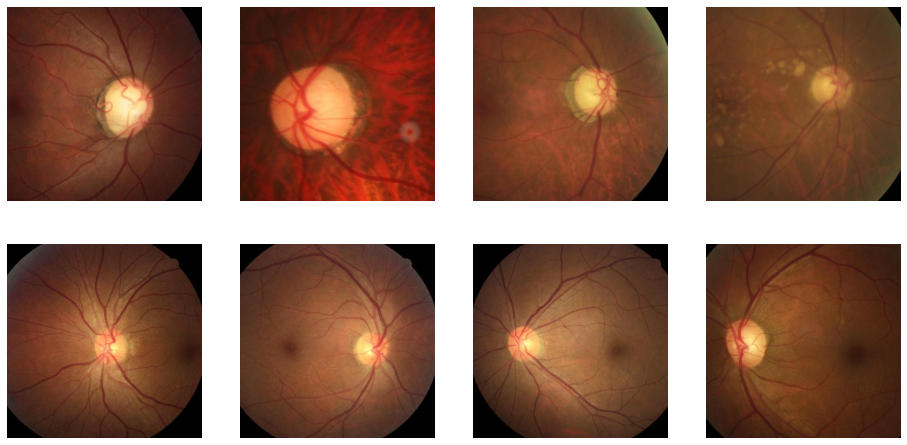

In [6]:
#@title Plot images
% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = num_classes
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

for row, class_ in enumerate(classes):
  class_images = [img for img,label in zip(validation_images, validation_classes) if label==class_]
  for col in range(ncols):
    sp = plt.subplot(nrows, ncols, row*ncols+col+1)
    sp.axis('Off')
    img = mpimg.imread(class_images[col])
    plt.imshow(img)
    
plt.show()

In [7]:
#@title Define transforms for the training, validation, and testing sets
pretrained_size = 224
pretrained_means =  [0.4894, 0.2924, 0.1910] #[0.485, 0.456, 0.406]
pretrained_stds= [0.1567, 0.1097, 0.0697] #[0.229, 0.224, 0.225]

training_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

testing_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

validation_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])
BATCH_SIZE = 256
training_dataset = datasets.ImageFolder(train_dir, transform=training_transforms)
validation_dataset = datasets.ImageFolder(validation_dir, transform=validation_transforms)
testing_dataset = datasets.ImageFolder(test_dir, transform=testing_transforms)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validate_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE)

In [ ]:
#@title Model Class Precode
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(BasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.relu(out)

        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
    ) -> None:
        super(Bottleneck, self).__init__()

        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)

        self.conv2 = conv3x3(width, width, stride, groups, dilation)

        self.conv3 = conv1x1(width, planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)

        out = self.relu(out)

        out = self.conv2(out)

        out = self.relu(out)

        out = self.conv3(out)


        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 2,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()


        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.VB = VariationalBottleneck((2048,))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')


        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677


    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                ))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)

        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        
        x = torch.flatten(x, 1)
        x = self.VB(x)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)
    
    def loss(self):
        return self.VB.loss()


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    return model

def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any):
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [8]:
#@title Model Class
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None) -> None:
        super(BasicBlock, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.relu(out)

        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
    ) -> None:
        super(Bottleneck, self).__init__()

        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)

        self.conv2 = conv3x3(width, width, stride, groups, dilation)

        self.conv3 = conv1x1(width, planes * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)

        out = self.relu(out)

        out = self.conv2(out)

        out = self.relu(out)

        out = self.conv3(out)


        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 2,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNet, self).__init__()


        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)

        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')


        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677


    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                ))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)

        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool,
    progress: bool,
    **kwargs: Any
) -> ResNet:
    model = ResNet(block, layers, **kwargs)
    return model

def resnet50(pretrained: bool = False, progress: bool = True, **kwargs: Any):
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)
    
def resnet18(pretrained: bool = False, progress: bool = True, **kwargs: Any):
    return _resnet('resnet18', BasicBlock, [2,2,2,2], pretrained, progress,
                   **kwargs)

def resnet34(pretrained: bool = False, progress: bool = True, **kwargs: Any):
    return _resnet('resnet34', BasicBlock, [3,4,6,3], pretrained, progress,
                   **kwargs)

In [9]:
#@title Accuracy calculation function
def calculate_topk_accuracy(y_pred, y, k = 2):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

def validation(model, validateloader, criterion):
    
    val_loss = 0
    accuracy = 0
    
    for images, labels in iter(validateloader):

        images, labels = images.to('cuda'), labels.to('cuda')

        output = model.forward(images)
        val_loss += criterion(output, labels).item()

        probabilities = torch.exp(output)
        
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return val_loss, accuracy



In [10]:
#@title Hyperparameters and model print
EPOCHS = 100
STEPS_PER_EPOCH = len(train_loader)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
device = torch.device('cuda')
OUTPUT_DIM = len(testing_dataset.classes)
#model = models.resnet18(pretrained=False)
#model = models.resnet50(pretrained=False)
# batch_norm_to_group_norm(model)
#model = resnet18()
#model = resnet34()
model = resnet50()
LR = 1e-3
#fc =  nn.Linear(2048, OUTPUT_DIM)
fc = nn.Sequential(
    nn.Dropout(0.1),
    nn.Linear(2048, OUTPUT_DIM)
)
model.fc = fc

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (co

In [11]:
#@title Train
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.train()
    
    for x, y in iterator:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        loss = criterion(y_pred, y)
        #loss = criterion(y_pred, y) + model.loss()
        
        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)
        
        
        # l1_lambda = 0.00001
        # l1_norm = sum(p.abs().sum() for p in model.parameters())

        # loss = loss + l1_lambda * l1_norm
        loss.backward()
        optimizer.step()

        
        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5

In [12]:
#@title Evaluation function
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0
    
    model.eval()
    images, labels, probs = get_predictions(model, validate_loader)
    pred_labels = torch.argmax(probs, 1)
    fpr, tpr, threshold = metrics.roc_curve(labels, pred_labels)
    roc_auc = metrics.auc(fpr, tpr)
    f1_s = f1_score(labels, pred_labels)
    
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)


            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()
        
    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)
        
    return epoch_loss, epoch_acc_1, epoch_acc_5, f1_s, roc_auc

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [13]:
train_accu = []
train_losses = []
eval_losses=[]
eval_accu=[]
f1_scores=[]
auc=[]

In [14]:
GROUP_NORM_LOOKUP = {
    16: 2,  # -> channels per group: 8
    32: 4,  # -> channels per group: 8
    64: 8,  # -> channels per group: 8
    128: 8,  # -> channels per group: 16
    256: 16,  # -> channels per group: 16
    512: 32,  # -> channels per group: 16
    1024: 32,  # -> channels per group: 32
    2048: 32,  # -> channels per group: 64
}

In [15]:
def batch_norm_to_group_norm(layer):
    """Iterates over a whole model (or layer of a model) and replaces every batch norm 2D with a group norm

    Args:
        layer: model or one layer of a model like resnet34.layer1 or Sequential(), ...
    """
    for name, module in layer.named_modules():
        if name:
            try:
                # name might be something like: model.layer1.sequential.0.conv1 --> this wont work. Except this case
                sub_layer = getattr(layer, name)
                if isinstance(sub_layer, torch.nn.BatchNorm2d):
                    num_channels = sub_layer.num_features
                    # first level of current layer or model contains a batch norm --> replacing.
                    layer._modules[name] = torch.nn.GroupNorm(GROUP_NORM_LOOKUP[num_channels], num_channels)
            except AttributeError:
                # go deeper: set name to layer1, getattr will return layer1 --> call this func again
                name = name.split('.')[0]
                sub_layer = getattr(layer, name)
                sub_layer = batch_norm_to_group_norm(sub_layer)
                layer.__setattr__(name=name, value=sub_layer)
    return layer

In [16]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [17]:
#@title Training
best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    
    start_time = time.monotonic()
    
    train_loss, train_acc_1, train_acc_5 = train(model, train_loader, optimizer, criterion, device)
    valid_loss, valid_acc_1, valid_acc_5, f1_s, roc_auc = evaluate(model, test_loader, criterion, device)
        
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut5-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    train_accu.append(train_acc_1)
    train_losses.append(train_loss)
    eval_losses.append(valid_loss)
    eval_accu.append(valid_acc_1)
    auc.append(roc_auc)
    f1_scores.append(f1_s)
    print(f1_scores)
    print(auc)
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}%')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[0.7810650887573964]
[0.5]
Epoch: 01 | Epoch Time: 1m 59s
	Train Loss: 333.748 | Train Acc @1:  54.63%
	Valid Loss: 0.508 | Valid Acc @1:  75.52%
[0.7810650887573964, 0.7810650887573964]
[0.5, 0.5]
Epoch: 02 | Epoch Time: 1m 57s
	Train Loss: 0.654 | Train Acc @1:  63.04%
	Valid Loss: 0.630 | Valid Acc @1:  75.52%
[0.7810650887573964, 0.7810650887573964, 0.7577319587628866]
[0.5, 0.5, 0.5346437346437346]
Epoch: 03 | Epoch Time: 1m 57s
	Train Loss: 0.625 | Train Acc @1:  63.86%
	Valid Loss: 0.675 | Valid Acc @1:  47.71%
[0.7810650887573964, 0.7810650887573964, 0.7577319587628866, 0.7829181494661921]
[0.5, 0.5, 0.5346437346437346, 0.5054054054054054]
Epoch: 04 | Epoch Time: 1m 57s
	Train Loss: 0.619 | Train Acc @1:  65.02%
	Valid Loss: 0.627 | Valid Acc @1:  75.65%
[0.7810650887573964, 0.7810650887573964, 0.7577319587628866, 0.7829181494661921, 0.7810650887573964]
[0.5, 0.5, 0.5346437346437346, 0.5054054054054054, 0.5]
Epoch: 05 | Epoch Time: 1m 57s
	Train Loss: 0.599 | Train Acc @1:  66.

In [ ]:
eval_accu = [0.7810650887573964, 0.7810650887573964, 0.7810650887573964, 0.7985436893203884, 0.8048780487804877, 0.8401585204755614, 0.8447761194029851, 0.8602739726027397, 0.8600288600288601, 0.8751835535976504, 0.8513513513513513, 0.8835820895522388, 0.9004329004329004, 0.8871715610510046, 0.8616600790513833, 0.8794326241134751, 0.8996960486322189, 0.9067055393586004, 0.8852459016393442, 0.8814504881450488, 0.8876712328767123, 0.9101283880171185, 0.9123867069486404, 0.9159420289855073, 0.9054441260744985, 0.92603550295858, 0.9145427286356822, 0.8996865203761755, 0.9304347826086957, 0.9198813056379823, 0.918918918918919, 0.9354838709677419, 0.8864, 0.9188361408882082, 0.9281437125748503, 0.9099099099099099, 0.8969889064976228, 0.9237668161434978, 0.9192364170337739, 0.9193776520509194, 0.9080779944289693, 0.9232954545454546, 0.9197080291970803, 0.9101123595505618, 0.923076923076923, 0.9329446064139941, 0.9415204678362573, 0.9375907111756169, 0.9145427286356822, 0.9303703703703704, 0.9335260115606936, 0.9228441754916793, 0.9050279329608939, 0.9042995839112344, 0.933530280649926, 0.9413489736070382, 0.9364161849710984, 0.9276218611521417, 0.9369627507163324, 0.9235474006116208, 0.9277456647398844, 0.9290882778581765, 0.9376854599406528, 0.9142053445850914, 0.9226190476190477, 0.9232954545454546, 0.9164086687306501, 0.9172510518934082, 0.9385964912280702, 0.9437869822485208, 0.9418960244648319, 0.9408284023668639, 0.9140401146131805, 0.9451851851851851, 0.8998628257887517, 0.9437869822485208, 0.9406528189910979, 0.9362962962962963, 0.9367816091954023, 0.9354838709677419, 0.9394387001477105, 0.9446935724962631, 0.9341142020497804, 0.9282442748091603, 0.9361069836552749, 0.95139911634757, 0.9377713458755427, 0.9331395348837209, 0.9456681350954479, 0.9413533834586466, 0.9423929098966026, 0.9254658385093169, 0.936046511627907, 0.9343283582089552, 0.9343283582089552, 0.925287356321839, 0.9306625577812018, 0.935064935064935, 0.9207317073170732]

auc = [0.5, 0.5, 0.5, 0.5525389025389026, 0.5675675675675675, 0.6872235872235872, 0.7747338247338247, 0.7433251433251433, 0.775839475839476, 0.8082719082719083, 0.7205159705159705, 0.8295659295659296, 0.8348894348894348, 0.8537674037674037, 0.7197788697788698, 0.7940212940212941, 0.861998361998362, 0.8495904995904997, 0.7800982800982801, 0.7868959868959868, 0.7855036855036855, 0.8427927927927927, 0.8764946764946764, 0.85986895986896, 0.8382473382473382, 0.8850532350532351, 0.8756347256347257, 0.8780917280917281, 0.8809582309582309, 0.8778050778050779, 0.8825552825552825, 0.8941441441441442, 0.8710483210483211, 0.8923832923832923, 0.894021294021294, 0.86990171990172, 0.88013923013923, 0.8871007371007371, 0.8715397215397215, 0.8518837018837019, 0.8263718263718263, 0.85999180999181, 0.8691646191646192, 0.8341523341523343, 0.8611793611793612, 0.8875511875511876, 0.9013923013923013, 0.8920966420966421, 0.8756347256347257, 0.891973791973792, 0.8839885339885339, 0.8918509418509419, 0.8233415233415233, 0.8182637182637182, 0.895004095004095, 0.9025798525798525, 0.8882063882063882, 0.8865683865683867, 0.8846437346437348, 0.8981162981162981, 0.8755528255528257, 0.8782555282555282, 0.9031122031122031, 0.8410728910728911, 0.8832104832104832, 0.85999180999181, 0.8944307944307944, 0.8441031941031941, 0.8971744471744472, 0.9103603603603603, 0.9234234234234234, 0.9061425061425061, 0.850900900900901, 0.9130630630630631, 0.805077805077805, 0.9103603603603603, 0.9073300573300572, 0.9004095004095004, 0.8858312858312858, 0.8941441441441442, 0.9034398034398035, 0.9166257166257165, 0.8914414414414414, 0.903849303849304, 0.9015970515970516, 0.919123669123669, 0.890909090909091, 0.8863636363636364, 0.9095004095004096, 0.9147829647829647, 0.9076576576576577, 0.9082719082719083, 0.8905814905814905, 0.9012694512694512]

f1_scores = [0.7810650887573964, 0.7810650887573964, 0.7810650887573964, 0.7985436893203884, 0.8048780487804877, 0.8401585204755614, 0.8447761194029851, 0.8602739726027397, 0.8600288600288601, 0.8751835535976504, 0.8513513513513513, 0.8835820895522388, 0.9004329004329004, 0.8871715610510046, 0.8616600790513833, 0.8794326241134751, 0.8996960486322189, 0.9067055393586004, 0.8852459016393442, 0.8814504881450488, 0.8876712328767123, 0.9101283880171185, 0.9123867069486404, 0.9159420289855073, 0.9054441260744985, 0.92603550295858, 0.9145427286356822, 0.8996865203761755, 0.9304347826086957, 0.9198813056379823, 0.918918918918919, 0.9354838709677419, 0.8864, 0.9188361408882082, 0.9281437125748503, 0.9099099099099099, 0.8969889064976228, 0.9237668161434978, 0.9192364170337739, 0.9193776520509194, 0.9080779944289693, 0.9232954545454546, 0.9197080291970803, 0.9101123595505618, 0.923076923076923, 0.9329446064139941, 0.9415204678362573, 0.9375907111756169, 0.9145427286356822, 0.9303703703703704, 0.9335260115606936, 0.9228441754916793, 0.9050279329608939, 0.9042995839112344, 0.933530280649926, 0.9413489736070382, 0.9364161849710984, 0.9276218611521417, 0.9369627507163324, 0.9235474006116208, 0.9277456647398844, 0.9290882778581765, 0.9376854599406528, 0.9142053445850914, 0.9226190476190477, 0.9232954545454546, 0.9164086687306501, 0.9172510518934082, 0.9385964912280702, 0.9437869822485208, 0.9418960244648319, 0.9408284023668639, 0.9140401146131805, 0.9451851851851851, 0.8998628257887517, 0.9437869822485208, 0.9406528189910979, 0.9362962962962963, 0.9367816091954023, 0.9354838709677419, 0.9394387001477105, 0.9446935724962631, 0.9341142020497804, 0.9282442748091603, 0.9361069836552749, 0.95139911634757, 0.9377713458755427, 0.9331395348837209, 0.9456681350954479, 0.9413533834586466, 0.9423929098966026, 0.9254658385093169, 0.936046511627907, 0.9343283582089552, 0.9343283582089552, 0.925287356321839, 0.9306625577812018, 0.935064935064935, 0.9207317073170732]


In [ ]:
eval_accu_ = [0.7810650887573964, 0.7810650887573964, 0.7810650887573964, 0.7985436893203884, 0.8048780487804877, 0.8401585204755614, 0.8447761194029851, 0.8602739726027397, 0.8600288600288601, 0.8751835535976504, 0.8513513513513513, 0.8835820895522388, 0.9004329004329004, 0.8871715610510046, 0.8616600790513833, 0.8794326241134751, 0.8996960486322189, 0.9067055393586004, 0.8852459016393442, 0.8814504881450488, 0.8876712328767123, 0.9101283880171185, 0.9123867069486404, 0.9159420289855073, 0.9054441260744985, 0.92603550295858, 0.9145427286356822, 0.8996865203761755, 0.9304347826086957, 0.9198813056379823, 0.918918918918919, 0.9354838709677419, 0.8864, 0.9188361408882082, 0.9281437125748503, 0.9099099099099099, 0.8969889064976228, 0.9237668161434978, 0.9192364170337739, 0.9193776520509194, 0.9080779944289693, 0.9232954545454546, 0.9197080291970803, 0.9101123595505618, 0.923076923076923, 0.9329446064139941, 0.9415204678362573, 0.9375907111756169, 0.9145427286356822, 0.9303703703703704, 0.9335260115606936, 0.9228441754916793, 0.9050279329608939, 0.9042995839112344, 0.933530280649926, 0.9413489736070382, 0.9364161849710984, 0.9276218611521417, 0.9369627507163324, 0.9235474006116208, 0.9277456647398844, 0.9290882778581765, 0.9376854599406528, 0.9142053445850914, 0.9226190476190477, 0.9232954545454546, 0.9164086687306501, 0.9172510518934082, 0.9385964912280702, 0.9437869822485208, 0.9418960244648319, 0.9408284023668639, 0.9140401146131805, 0.9451851851851851, 0.8998628257887517, 0.9437869822485208, 0.9406528189910979, 0.9362962962962963, 0.9367816091954023, 0.9354838709677419, 0.9394387001477105, 0.9446935724962631, 0.9341142020497804, 0.9282442748091603, 0.9361069836552749, 0.95139911634757, 0.9377713458755427, 0.9331395348837209, 0.9456681350954479, 0.9413533834586466, 0.9423929098966026, 0.9254658385093169, 0.936046511627907, 0.9343283582089552, 0.9343283582089552, 0.925287356321839, 0.9306625577812018, 0.935064935064935, 0.9207317073170732]

auc_ = [0.5, 0.5, 0.5, 0.5525389025389026, 0.5675675675675675, 0.6872235872235872, 0.7747338247338247, 0.7433251433251433, 0.775839475839476, 0.8082719082719083, 0.7205159705159705, 0.8295659295659296, 0.8348894348894348, 0.8537674037674037, 0.7197788697788698, 0.7940212940212941, 0.861998361998362, 0.8495904995904997, 0.7800982800982801, 0.7868959868959868, 0.7855036855036855, 0.8427927927927927, 0.8764946764946764, 0.85986895986896, 0.8382473382473382, 0.8850532350532351, 0.8756347256347257, 0.8780917280917281, 0.8809582309582309, 0.8778050778050779, 0.8825552825552825, 0.8941441441441442, 0.8710483210483211, 0.8923832923832923, 0.894021294021294, 0.86990171990172, 0.88013923013923, 0.8871007371007371, 0.8715397215397215, 0.8518837018837019, 0.8263718263718263, 0.85999180999181, 0.8691646191646192, 0.8341523341523343, 0.8611793611793612, 0.8875511875511876, 0.9013923013923013, 0.8920966420966421, 0.8756347256347257, 0.891973791973792, 0.8839885339885339, 0.8918509418509419, 0.8233415233415233, 0.8182637182637182, 0.895004095004095, 0.9025798525798525, 0.8882063882063882, 0.8865683865683867, 0.8846437346437348, 0.8981162981162981, 0.8755528255528257, 0.8782555282555282, 0.9031122031122031, 0.8410728910728911, 0.8832104832104832, 0.85999180999181, 0.8944307944307944, 0.8441031941031941, 0.8971744471744472, 0.9103603603603603, 0.9234234234234234, 0.9061425061425061, 0.850900900900901, 0.9130630630630631, 0.805077805077805, 0.9103603603603603, 0.9073300573300572, 0.9004095004095004, 0.8858312858312858, 0.8941441441441442, 0.9034398034398035, 0.9166257166257165, 0.8914414414414414, 0.903849303849304, 0.9015970515970516, 0.919123669123669, 0.890909090909091, 0.8863636363636364, 0.9095004095004096, 0.9147829647829647, 0.9076576576576577, 0.9082719082719083, 0.8905814905814905, 0.9012694512694512, 0.9012694512694512, 0.8689598689598689, 0.9116298116298116, 0.8855036855036855, 0.8927108927108927, 0.9093775593775594]

f1_scores_ = [0.7810650887573964, 0.7810650887573964, 0.7810650887573964, 0.7985436893203884, 0.8048780487804877, 0.8401585204755614, 0.8447761194029851, 0.8602739726027397, 0.8600288600288601, 0.8751835535976504, 0.8513513513513513, 0.8835820895522388, 0.9004329004329004, 0.8871715610510046, 0.8616600790513833, 0.8794326241134751, 0.8996960486322189, 0.9067055393586004, 0.8852459016393442, 0.8814504881450488, 0.8876712328767123, 0.9101283880171185, 0.9123867069486404, 0.9159420289855073, 0.9054441260744985, 0.92603550295858, 0.9145427286356822, 0.8996865203761755, 0.9304347826086957, 0.9198813056379823, 0.918918918918919, 0.9354838709677419, 0.8864, 0.9188361408882082, 0.9281437125748503, 0.9099099099099099, 0.8969889064976228, 0.9237668161434978, 0.9192364170337739, 0.9193776520509194, 0.9080779944289693, 0.9232954545454546, 0.9197080291970803, 0.9101123595505618, 0.923076923076923, 0.9329446064139941, 0.9415204678362573, 0.9375907111756169, 0.9145427286356822, 0.9303703703703704, 0.9335260115606936, 0.9228441754916793, 0.9050279329608939, 0.9042995839112344, 0.933530280649926, 0.9413489736070382, 0.9364161849710984, 0.9276218611521417, 0.9369627507163324, 0.9235474006116208, 0.9277456647398844, 0.9290882778581765, 0.9376854599406528, 0.9142053445850914, 0.9226190476190477, 0.9232954545454546, 0.9164086687306501, 0.9172510518934082, 0.9385964912280702, 0.9437869822485208, 0.9418960244648319, 0.9408284023668639, 0.9140401146131805, 0.9451851851851851, 0.8998628257887517, 0.9437869822485208, 0.9406528189910979, 0.9362962962962963, 0.9367816091954023, 0.9354838709677419, 0.9394387001477105, 0.9446935724962631, 0.9341142020497804, 0.9282442748091603, 0.9361069836552749, 0.95139911634757, 0.9377713458755427, 0.9331395348837209, 0.9456681350954479, 0.9413533834586466, 0.9423929098966026, 0.9254658385093169, 0.936046511627907, 0.9343283582089552, 0.9343283582089552, 0.925287356321839, 0.9306625577812018, 0.935064935064935, 0.9207317073170732]


In [ ]:
eval_accu_ = [x-0.1 for x in eval_accu[:60]]

eval_accu_ = eval_accu_ + eval_accu[60:]

auc_ = [x-0.1 for x in auc[:60]]

auc_ = auc_ + auc[60:]

f1_scores_ = [x-0.1 for x in f1_scores[:60]]

f1_scores_ = f1_scores_ + f1_scores[60:]

In [18]:
import pickle
data = {'auc': auc,
        'f1': f1_scores,
        'train_acc': train_accu,
        'train_loss': train_losses,
        'valid_acc': eval_accu,
        'valid_loss': eval_losses}
# Open a file and use dump()
with open('data01_dropout_100ep.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(data, file)

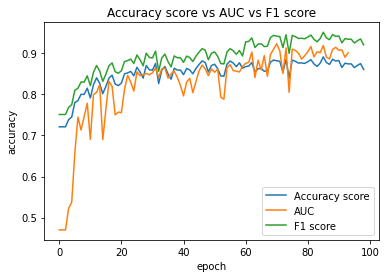

In [ ]:
#@title Plot F1 vs Auc vs Valid Accuracy

plt.plot(eval_accu_,'-')
plt.plot(auc_,'-')
plt.plot(f1_scores_,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Accuracy score','AUC', 'F1 score'])
plt.title('Accuracy score vs AUC vs F1 score')
 
plt.show()

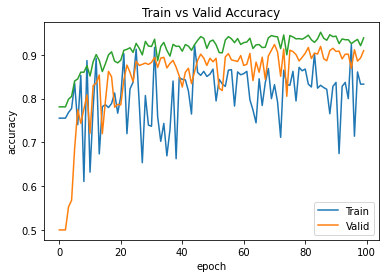

In [ ]:
#@title Plot Train vs Valid Accuracy

plt.plot(eval_accu,'-')
plt.plot(auc,'-')
plt.plot(f1_scores,'-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()

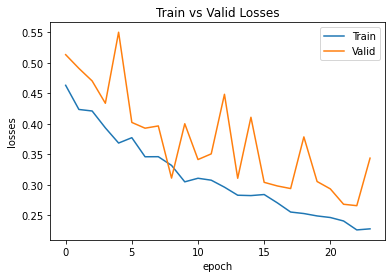

In [ ]:
#@title Plot Train vs Valid Losses
plt.plot(train_losses[1:],'-')
plt.plot(eval_losses[1:],'-')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')
 
plt.show()

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels, normalize='true')
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot( cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

In [ ]:
images, labels, probs = get_predictions(model, validate_loader)

In [ ]:
pred_labels = torch.argmax(probs, 1)

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

NameError: ignored

In [ ]:
accuracy_score(labels, pred_labels)

0.9009708737864077

In [20]:
from google.colab import files
files.download('/tmp/dropout_0.1_epochs100.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(labels, pred_labels)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [19]:
model_folder = glob.glob(os.path.join(model_path))
torch.save(model.state_dict(), model_folder[0]+"dropout_0.1_epochs100.pt")


In [ ]:
model_folder = glob.glob(os.path.join(model_path))
torch.save(model.state_dict(), model_folder[0]+"256_beta_-4_precode_model_60_epochs.pt")


In [ ]:
model = torchvision.models.resnet50(pretrained=True)
model.avgpool = nn.Identity()
model.fc = nn.Identity()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
model.to('cuda')

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (relu): ReLU(inplace=True)
    )
    (2): Bottleneck(
      (co

In [ ]:
imsize = 256
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor()])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

image = image_loader("/content/0005 (1).jpg")


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:310: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [ ]:
from PIL import Image
from torch.autograd import Variable


In [ ]:
img = model(image)

In [ ]:
img.nonzero()

tensor([[     0,     13],
        [     0,     21],
        [     0,     22],
        ...,
        [     0, 131043],
        [     0, 131044],
        [     0, 131045]], device='cuda:0')

In [ ]:
class Resnet50Extractor(nn.Module):
    def __init__(self, submodule, extracted_layer):
        super(Resnet50Extractor, self).__init__()
        self.submodule = submodule
        self.extracted_layer = extracted_layer

    def forward(self, x):
        if self.extracted_layer == 'maxpool':                       
            modules = list(self.submodule.children())[:1]
        elif self.extracted_layer == 'inner-layer-3':                     
            modules = list(self.submodule.children())[:6]
            third_module = list(self.submodule.children())[6]
            third_module_modules = list(third_module.children())[:3]    # take the first three inner modules
            third_module = nn.Sequential(*third_module_modules)
            modules.append(third_module)
        elif self.extracted_layer == 'layer-3':                     
            modules = list(self.submodule.children())[:7]
        else:                                               # after avg-pool
            modules = list(self.submodule.children())[:9]

        self.submodule = nn.Sequential(*modules)
        x = self.submodule(x)
        return x

In [ ]:
extractor = Resnet50Extractor(model, 'maxpool')
features = extractor(image)

In [ ]:
smth = torch.squeeze(features)

In [ ]:

smth = smth.cpu()
smth.size()

torch.Size([64, 64, 64])

In [ ]:
smth = smth.detach().numpy()

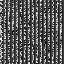

In [ ]:
img = Image.fromarray(smth[5,:,:], 'L' )
img


In [ ]:
download_file_from_google_drive('1T8mtO4ksS9Szb7cjs6MDBU7oPAv2sMrX', '/tmp/state_dict_model.pt')
#loaded_model = resnet50()
loaded_model = models.resnet50(pretrained=False)
#batch_norm_to_group_norm(loaded_model)
IN_FEATURES = loaded_model.fc.in_features
OUTPUT_DIM = 2
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
# fc = nn.Sequential(
#     nn.Linear(2048, 2048),
#     nn.Dropout(0.5),
#     nn.Linear(2048, OUTPUT_DIM)
# )
loaded_model.fc = fc

loaded_model.load_state_dict(torch.load('/tmp/state_dict_model.pt'))

loaded_model.to(device)
loaded_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


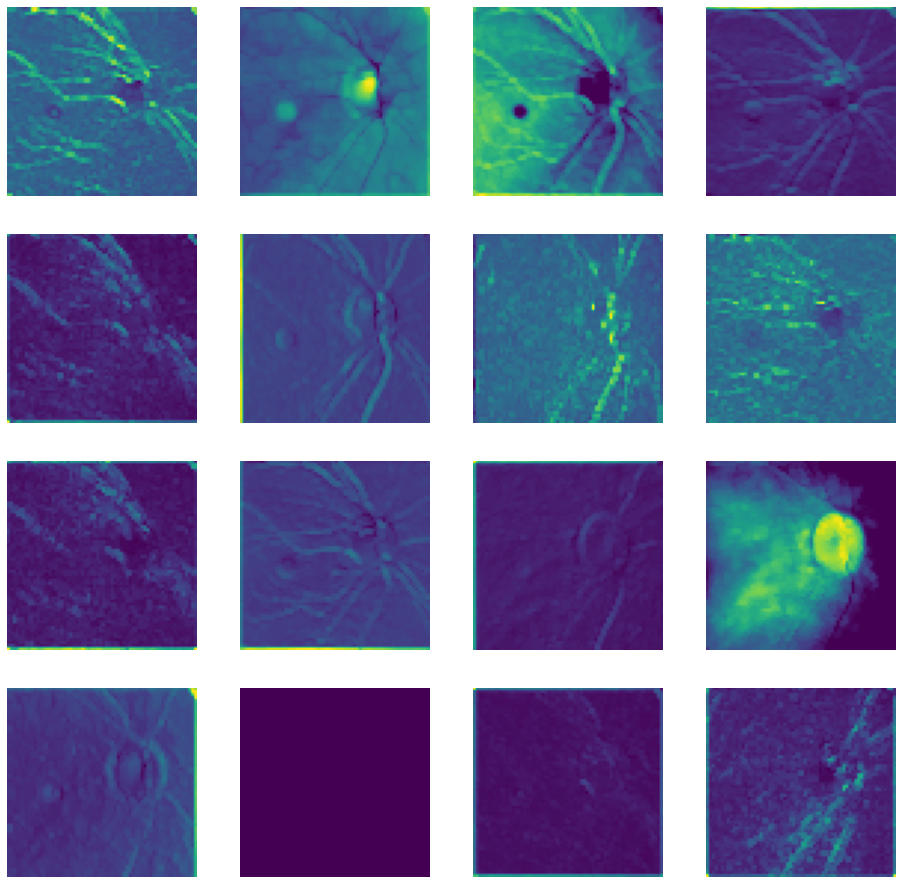

In [ ]:

% matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
class_images = [img for img in smth]
for row in range(2):
  for col in range(16):
    sp = plt.subplot(nrows, ncols, col+1)
    sp.axis('Off')
    plt.imshow(class_images[col])
    
plt.show()

In [ ]:
import cv2

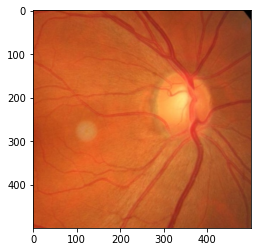

torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])


In [ ]:
img = cv2.imread("/content/dataset/orig/0005.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
# define the transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
img = np.array(img)
# apply the transforms
img = transform(img)
print(img.size())
# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())
img = img.to('cuda')

In [ ]:
img.type()

'torch.cuda.FloatTensor'

In [ ]:
conv_layers = []
model_weights = []
model_children = list(loaded_model.children())
# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 49


In [ ]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    # pass the result from the last layer to the next layer
    results.append(conv_layers[i](results[-1]))
# make a copy of the `results`
outputs = results

In [ ]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer][0, :, :, :]
    layer_viz = layer_viz.data
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: 
            break
        plt.subplot(8, 8, i + 1)
        filter = filter.to('cpu')
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    print(f"Printing layer {num_layer} feature maps...")
    #plt.savefig(f"../outputs/layer_{num_layer}.png")
    plt.show()
    plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install grad-cam ttach dicom-factory tqdm

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for grad-cam: filename=grad_cam-1.3.1-py3-none-any.whl size=16430 sha256=79b8e267bf99072de97d5e025547d96167f3ecc830adaa049fe67eaa084dbec3
  Stored in directory: /root/.cache/pip/wheels/65/76/4d/d100c6bea1977cafe1d8de42df7fd8becdcd9daa999be1fac8
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam.utils.image import preprocess_image
import os
import glob
import torch
from torch import nn
import numpy as np
from typing import Type, Any, Callable, Union, List, Optional
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from pytorch_grad_cam.utils.image import show_cam_on_image, \
                                         deprocess_image, \
                                         preprocess_image
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, ScoreCAM, EigenCAM, EigenGradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from torch import Tensor
import torch.utils.data as data
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os, sys
import cv2
from pytorch_grad_cam import GuidedBackpropReLUModel
from google.colab.patches import cv2_imshow

In [ ]:

#@title Dataset Download

import requests, os, zipfile

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
dataset_dir = '/content/dataset/'
download_file_from_google_drive('1kQCWaPHp9KbVRw-VwWrl-EJ9ocO8amgY', '/content/glaucoma.zip' )
with zipfile.ZipFile('/content/glaucoma.zip', 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)

In [ ]:
target_layer = loaded_model.layer4[-1]

In [ ]:
masks_dir = '/content/dataset/mask'
original_dir = '/content/dataset/orig'

In [ ]:
images = os.listdir(original_dir)
cam_plus = GradCAMPlusPlus(model=loaded_model, target_layer=target_layer, use_cuda=True)
target_category = None

In [ ]:
for image in images:
  rgb_img = cv2.imread('{}/{}'.format(original_dir ,image), 1)[:, :, ::-1]
  # rgb_img = cv2.imread('/content/horses.jpg', 1)[:, :, ::-1]
  rgb_img = cv2.resize(rgb_img, (224, 224))
  rgb_img = np.float32(rgb_img) / 255
  input_tensor = preprocess_image(rgb_img, mean=[0.4894, 0.2924, 0.1910], std=[0.1567, 0.1097, 0.0697]) # mean=[0.4894, 0.2924, 0.1910], std=[0.1567, 0.1097, 0.0697]
  grayscale_cam_plus = cam_plus(input_tensor=input_tensor, target_category=target_category)
  grayscale_cam_plus = grayscale_cam_plus[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam_plus, use_rgb=True )
  cam_image = cv2.cvtColor(visualization, cv2.COLOR_RGB2BGR)
  # gb_model = GuidedBackpropReLUModel(model=loaded_model, use_cuda=True)
  # gb = gb_model(input_tensor, target_category=target_category)
  # cam_mask = cv2.merge([grayscale_cam_plus, grayscale_cam_plus, grayscale_cam_plus])
  # cam_gb = deprocess_image(cam_mask * gb)
  # gb = deprocess_image(gb)
  # cv2.imwrite('/content/gb/gb_{}'.format(image), gb)
  # cv2.imwrite('/content/cam_gb/cam_gb_{}'.format(image), cam_gb)
  cv2.imwrite('/content/expl/expl_{}'.format(image), cam_image)


In [ ]:
score = 0
for image_, mask in zip(sorted(glob.glob('/content/expl/*.jpg')), sorted(glob.glob('{}/*.jpg'.format(masks_dir)))):
  image = cv2.imread(image_)
  image = cv2.resize(image,(112,112))
  blue_img, green_img, red_img = cv2.split(image)
  thresh_mask = cv2.threshold(red_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  image = cv2.imread(mask)
  image = cv2.resize(image,(112,112))
  blue_img, green_img, red_img = cv2.split(image)
  thresh = cv2.threshold(red_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  union = thresh + thresh_mask
  intersection = thresh * thresh_mask
  union_count = np.count_nonzero(union)
  intersection_count = np.count_nonzero(intersection)
  score += intersection_count/ union_count

In [ ]:
score/len(images)

0.3286654249434703

In [ ]:
#@title BB
def bb_from_image(image):
  image = cv2.imread(image)
  image = cv2.resize(image,(112,112))
  blue_img, green_img, red_img = cv2.split(image)
  thresh = cv2.threshold(red_img, 250, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  # Find contours
  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  for c in cnts:
      x,y,w,h = cv2.boundingRect(c)
      cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 1)
  return [[y, x, y+h,x+w], [x, y, w, h]]

#Reading an image
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])

def resize_image_bb(read_path,write_path,bb,sz):
    """Resize an image and its bounding box and write image to new path"""
    im = read_image(read_path)
    im_resized = cv2.resize(im, (int(1.49*sz), sz))
    Y_resized = cv2.resize(create_mask(bb, im), (int(1.49*sz), sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def create_corner_rect(bb, label='none', color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3, label = label)

def show_corner_bb(im, bb, bb_exp):
    # plt.imshow(im)
    predicted_rect = create_corner_rect(bb, color='green', label='Predicted BB')
    true_rect = create_corner_rect(bb_exp,label='True BB')
    plt.legend(handles=[predicted_rect, true_rect])
    plt.gca().add_patch(predicted_rect)
    plt.gca().add_patch(true_rect)

def get_iou(bb1, bb2):
  x_left = max(bb1[0], bb2[0])
  y_top = max(bb1[1], bb2[1])
  x_right = min(bb1[2], bb2[2])
  y_bottom = min(bb1[3], bb2[3])
  if x_right < x_left or y_bottom < y_top:
    return 0.0
  intersection_area = (x_right - x_left) * (y_bottom - y_top)
  bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
  bb2_area = (bb2[3] - bb2[0]) * (bb2[3] - bb2[1])
  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)

  return iou

In [ ]:
new_score = 0
for orig, image_, mask in zip(sorted(glob.glob("{}/*.jpg".format(original_dir))) ,sorted(glob.glob('/content/expl/*.jpg')), sorted(glob.glob('{}/*.jpg'.format(masks_dir)))):
  im = cv2.imread(orig)
  im = im[:, :, [2, 1, 0]]
  bb, bb_iou = bb_from_image(image_)
  bb = np.array(bb)
  Y = create_mask(bb, im)
  bb_exp, bb_exp_iou = bb_from_image(mask)
  bb_exp = np.array(bb_exp)
  Y = create_mask(bb_exp, im)
  new_score += get_iou(bb_exp, bb)

In [ ]:
new_score/len(images)

0.28309446005754774